# The power of Python and SQLAlchemy

## Import dependencies

In [1]:
%matplotlib inline
from matplotlib import style

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

style.use('fivethirtyeight')

## Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#### Create an engine
The Engine is the starting point for any SQLAlchemy application. It’s “home base” for the actual database and its DBAPI, delivered to the SQLAlchemy application through a connection pool and a Dialect, which describes how to talk to a specific kind of database/DBAPI combination

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#### Reflect the existing database into a new model
This function produces a new base class that is a product of the AutomapBase class as well a declarative base produced by declarative.declarative_base().
All parameters other than declarative_base are keyword arguments that are passed directly to the declarative.declarative_base() function.

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

#### Alternate: Using inspector
A low level interface which provides a backend-agnostic system of loading lists of schema, table, column, and constraint descriptions from a given database

In [5]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
print (f'Columns from Measurement table\n--------------------------------------')
for c in columns:
    print(f'{c["name"]} | {c["type"]}')
print (f'--------------------------------------')    

columns = inspector.get_columns('station')
print (f'Columns from Station table\n--------------------------------------')
for c in columns:
    print(f'{c["name"]} | {c["type"]}')
    
#Lets see what the tables look like
conn = engine.connect()

test1 = pd.read_sql("SELECT * FROM Measurement", conn)
print (f'--------------------------------------\n{test1.head(10)}')

test2 = pd.read_sql("SELECT * FROM Station", conn)
print (f'--------------------------------------\n{test2.head(10)}')

Columns from Measurement table
--------------------------------------
id | INTEGER
station | TEXT
date | TEXT
prcp | FLOAT
tobs | FLOAT
--------------------------------------
Columns from Station table
--------------------------------------
id | INTEGER
station | TEXT
name | TEXT
latitude | FLOAT
longitude | FLOAT
elevation | FLOAT
--------------------------------------
   id      station        date  prcp  tobs
0   1  USC00519397  2010-01-01  0.08  65.0
1   2  USC00519397  2010-01-02  0.00  63.0
2   3  USC00519397  2010-01-03  0.00  74.0
3   4  USC00519397  2010-01-04  0.00  76.0
4   5  USC00519397  2010-01-06   NaN  73.0
5   6  USC00519397  2010-01-07  0.06  70.0
6   7  USC00519397  2010-01-08  0.00  64.0
7   8  USC00519397  2010-01-09  0.00  68.0
8   9  USC00519397  2010-01-10  0.00  73.0
9  10  USC00519397  2010-01-11  0.01  64.0
--------------------------------------
   id      station                                    name  latitude  \
0   1  USC00519397                    WAIKI

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Start date & Last date
start_date = session.query(Measurement.date).order_by(Measurement.date).first().date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print (f'First date in database: {start_date}')
print (f'Last date in database: {last_date}')

First date in database: 2010-01-01
Last date in database: 2017-08-23


([], <a list of 0 Text xticklabel objects>)

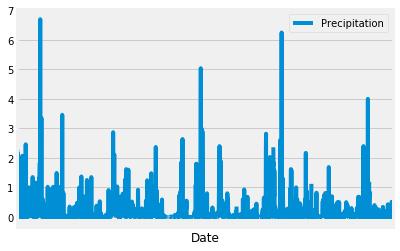

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_1yr = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame 
precipitation_df = pd.DataFrame(precipitation_1yr,columns = ['Date','Precipitation'])

# And set the index to the date column
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values(by=['Date'])
precipitation_df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.xticks([])

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
station_count

9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_counts = session.query(Measurement.station, func.count(Measurement.station)).filter(Measurement.tobs!="NaN").group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
most_active_station = stations_counts[0]
print (f'The most active staion is: {most_active_station[0]}')

The most active staion is: USC00519281


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()
print (f'The Min temp at the most active station {most_active_station[0]} is {most_active_station_info[0][0]}')
print (f'The Max temp at the most active station {most_active_station[0]} is {most_active_station_info[0][1]}')
print (f'The Avg temp at the most active station {most_active_station[0]} is {most_active_station_info[0][2]}')

The Min temp at the most active station USC00519281 is 54.0
The Max temp at the most active station USC00519281 is 85.0
The Avg temp at the most active station USC00519281 is 71.66378066378067


The station with the highest number of temperature observations: USC00519281


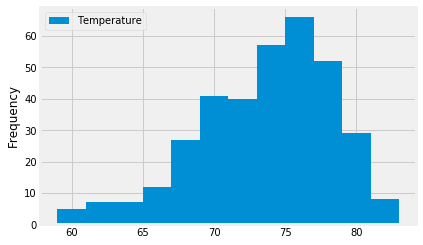

In [15]:
# Choose the station with the highest number of temperature observations.
no_temP_obs = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
print (f'The station with the highest number of temperature observations: {no_temP_obs[0][0]}')

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_1yr = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == no_temP_obs[0][0]).filter(Measurement.date>=one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame 
temperature_df = pd.DataFrame(temperature_1yr,columns = ['Date','Temperature'])

# And set the index to the date column
temperature_df.set_index('Date', inplace=True)
temperature_df.head()

temperature_df.plot.hist(bins=12)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Enter your vacation dates here

In [17]:
vacation_start = '2012-02-28'
vacation_end = '2012-03-05'

#### Lets analyze the dates

In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start_prev = dt.datetime.strptime(vacation_start, '%Y-%m-%d') - dt.timedelta(days=365)
vacation_end_prev = dt.datetime.strptime(vacation_end, '%Y-%m-%d') - dt.timedelta(days=365)
vacation_temps = calc_temps(vacation_start_prev, vacation_end_prev)
print (f' Min temp estimated during you vacation: {vacation_temps[0][0]}')
print (f' Max temp estimated during you vacation: {vacation_temps[0][2]}')
print (f' Avg temp estimated during you vacation: {vacation_temps[0][1]}')

 Min temp estimated during you vacation: 61.0
 Max temp estimated during you vacation: 75.0
 Avg temp estimated during you vacation: 70.17021276595744


<BarContainer object of 1 artists>

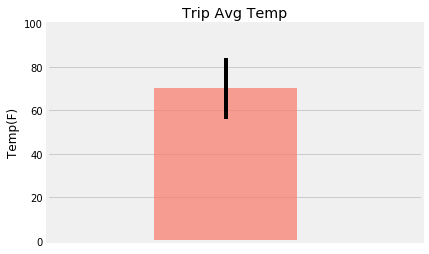

In [19]:
# Use the average temperature for the y value
ht = vacation_temps[0][1]

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = vacation_temps[0][2]-vacation_temps[0][0]

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')

# Plot the results from your previous query as a bar chart. 
plt.ylabel('Temp(F)')
plt.ylim(0,100)
plt.xlim(-1,1.1)
plt.xticks([])
plt.bar(0,ht,yerr=yerr, color='salmon', alpha=0.75)

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_trip = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp)) \
            .filter(Measurement.date.between(vacation_start_prev,vacation_end_prev)) \
            .filter(Measurement.station == Station.station) \
            .order_by(func.avg(Measurement.prcp).desc()) \
            .group_by(Measurement.station).all()

rain_trip_db = pd.DataFrame(rain_trip, columns = ['Station','Name', 'Latitude', 'Longitude', 'Elevation', 'Avg Precipitation'])
rain_trip_db

,Station,Name,Latitude,Longitude,Elevation,Avg Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.623333
1,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.582500
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.433333
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.433333
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.406667
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.281667
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.235000
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.126000
8,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
